In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Set random seed for reproducibility
np.random.seed(42)

def generate_mock_dataset(n_samples=2000):
    """Generate realistic mock patient dataset for fall risk prediction with correlated features"""
    
    # Patient demographics
    age = np.random.normal(72, 15, n_samples)
    age = np.clip(age, 18, 95)  # Realistic age range
    
    gender = np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55])
    
    # BMI with realistic distribution
    bmi = np.random.normal(26.5, 5.2, n_samples)
    bmi = np.clip(bmi, 15, 45)
    
    # Generate correlated medical conditions
    # Diabetes (influenced by age and BMI)
    diabetes_prob = 0.1 + 0.3 * (age > 65) + 0.2 * (bmi > 30)
    diabetes_prob = np.clip(diabetes_prob, 0, 0.8)
    diabetes = np.random.binomial(1, diabetes_prob, n_samples)
    
    # Hypertension (influenced by age, BMI, and diabetes)
    hypertension_prob = 0.15 + 0.25 * (age > 65) + 0.15 * (bmi > 30) + 0.2 * diabetes
    hypertension_prob = np.clip(hypertension_prob, 0, 0.85)
    hypertension = np.random.binomial(1, hypertension_prob, n_samples)
    
    # Depression (influenced by age and gender)
    depression_prob = 0.1 + 0.15 * (age > 70) + 0.1 * (gender == 'Female')
    depression_prob = np.clip(depression_prob, 0, 0.4)
    depression = np.random.binomial(1, depression_prob, n_samples)
    
    # Generate blood pressure values correlated with hypertension
    # For non-hypertensive patients
    systolic_bp_normal = np.random.normal(120, 12, n_samples)
    diastolic_bp_normal = np.random.normal(75, 8, n_samples)
    
    # For hypertensive patients (higher values)
    systolic_bp_high = np.random.normal(150, 18, n_samples)
    diastolic_bp_high = np.random.normal(92, 10, n_samples)
    
    # Combine based on hypertension status
    systolic_bp = np.where(hypertension == 1, systolic_bp_high, systolic_bp_normal)
    diastolic_bp = np.where(hypertension == 1, diastolic_bp_high, diastolic_bp_normal)
    
    # Ensure realistic ranges and maintain correlation
    systolic_bp = np.clip(systolic_bp, 90, 200)
    diastolic_bp = np.clip(diastolic_bp, 60, 110)
    
    # Ensure diastolic is always lower than systolic
    diastolic_bp = np.minimum(diastolic_bp, systolic_bp - 20)
    
    # Heart rate
    heart_rate = np.random.normal(75, 15, n_samples)
    heart_rate = np.clip(heart_rate, 50, 120)
    
    # Other medical conditions
    arthritis = np.random.choice([0, 1], n_samples, p=[0.65, 0.35])
    osteoporosis = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
    cognitive_impairment = np.random.choice([0, 1], n_samples, p=[0.85, 0.15])
    
    # Previous falls history
    previous_falls = np.random.poisson(0.8, n_samples)
    previous_falls = np.clip(previous_falls, 0, 10)
    
    # Generate medications correlated with conditions
    # Antihypertensives (strongly correlated with hypertension)
    antihypertensives_prob = 0.05 + 0.8 * hypertension  # 5% baseline, 85% if hypertensive
    antihypertensives = np.random.binomial(1, antihypertensives_prob, n_samples)
    
    # Antidepressants (strongly correlated with depression)
    antidepressants_prob = 0.03 + 0.75 * depression  # 3% baseline, 78% if depressed
    antidepressants = np.random.binomial(1, antidepressants_prob, n_samples)
    
    # Sedatives (influenced by age and depression)
    sedatives_prob = 0.08 + 0.12 * (age > 70) + 0.15 * depression
    sedatives_prob = np.clip(sedatives_prob, 0, 0.4)
    sedatives = np.random.binomial(1, sedatives_prob, n_samples)
    
    # Total medications (influenced by medical conditions)
    # base_medications = np.random.poisson(2, n_samples)
    # condition_medications = (diabetes + hypertension + depression + arthritis + 
    #                        osteoporosis + cognitive_impairment) * 1.5
    # num_medications = base_medications + condition_medications
    # num_medications = np.clip(num_medications, 0, 15)
    
    # Environmental factors
    assistive_device = np.random.choice(['None', 'Cane', 'Walker', 'Wheelchair'], 
                                        n_samples, p=[0.6, 0.25, 0.12, 0.03])
    
    # Create fall risk based on realistic risk factors
    fall_risk_score = (
        0.2 * (age - 65) / 10 +  # Age effect
        0.1 * (gender == 'Female') +  # Gender effect
        0.05 * (bmi > 30) +  # Obesity
        0.2 * diabetes +
        0.15 * hypertension +
        0.25 * arthritis +
        0.15 * osteoporosis +
        0.2 * depression +  # Added depression effect
        0.35 * cognitive_impairment +
        0.6 * (previous_falls > 0) +
        # 0.15 * (num_medications > 5) +
        0.2 * sedatives +
        0.15 * antihypertensives +
        0.1 * antidepressants +
        0.2 * (assistive_device != 'None')
    )
    
    # Add some noise and convert to binary outcome
    fall_risk_score += np.random.normal(0, 0.3, n_samples)
    fall_occurred = (fall_risk_score > np.percentile(fall_risk_score, 70)).astype(int)
    
    # Create DataFrame
    data = {
        'patient_id': range(1, n_samples + 1),
        'age': age,
        'gender': gender,
        'bmi': bmi,
        'systolic_bp': systolic_bp,
        'diastolic_bp': diastolic_bp,
        'heart_rate': heart_rate,
        'diabetes': diabetes,
        'hypertension': hypertension,
        'arthritis': arthritis,
        'osteoporosis': osteoporosis,
        'depression': depression,  # Added deression back
        'cognitive_impairment': cognitive_impairment,
        'previous_falls': previous_falls,
        # 'num_medications': num_medications,
        'sedatives': sedatives,
        'antihypertensives': antihypertensives,
        'antidepressants': antidepressants,
        'assistive_device': assistive_device,
        'fall_occurred': fall_occurred
    }
    
    df = pd.DataFrame(data)
    
    # Round numerical values appropriately
    df['age'] = df['age'].round(0).astype(int)
    df['bmi'] = df['bmi'].round(1)
    df['systolic_bp'] = df['systolic_bp'].round(0).astype(int)
    df['diastolic_bp'] = df['diastolic_bp'].round(0).astype(int)
    df['heart_rate'] = df['heart_rate'].round(0).astype(int)
    
    return df



In [33]:
df = generate_mock_dataset(n_samples=2000)

df.head(10)

,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,heart_rate,diabetes,hypertension,arthritis,osteoporosis,depression,cognitive_impairment,previous_falls,sedatives,antihypertensives,antidepressants,assistive_device,fall_occurred
0,1,79,Male,32.1,147,95,63,1,1,1,0,0,0,1,0,1,0,None,0
1,2,70,Male,29.6,141,88,102,0,1,0,0,0,0,0,0,0,0,None,0
2,3,82,Male,38.5,133,90,108,1,1,0,0,1,0,0,0,1,1,None,0
3,4,95,Male,18.8,172,83,70,1,1,1,0,1,0,1,0,1,1,Cane,1
4,5,68,Female,33.0,176,91,76,0,1,0,0,0,0,1,0,0,0,Wheelchair,0
5,6,68,Female,32.5,171,106,72,1,1,0,0,0,1,0,0,1,0,None,0
6,7,95,Male,21.4,112,69,92,0,0,1,0,0,0,1,0,0,0,None,0
7,8,84,Female,31.7,108,81,95,1,0,0,0,0,0,1,1,0,0,None,0
8,9,65,Female,28.2,127,68,50,0,0,0,0,0,1,0,0,0,0,None,0
9,10,80,Male,25.3,112,82,82,0,0,1,0,1,0,1,1,0,1,None,0


In [34]:
df['assistive_device'].unique()

array(['None', 'Cane', 'Wheelchair', 'Walker'], dtype=object)

In [35]:
df.columns

Index(['patient_id', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp',
       'heart_rate', 'diabetes', 'hypertension', 'arthritis', 'osteoporosis',
       'depression', 'cognitive_impairment', 'previous_falls', 'sedatives',
       'antihypertensives', 'antidepressants', 'assistive_device',
       'fall_occurred'],
      dtype='object')

In [36]:
#Converting categorical variables to numerical variables
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['assistive_device'] = df['assistive_device'].map({'None': 0, 'Cane': 1, 'Walker': 2, 'Wheelchair': 3})
df.head()

,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,heart_rate,diabetes,hypertension,arthritis,osteoporosis,depression,cognitive_impairment,previous_falls,sedatives,antihypertensives,antidepressants,assistive_device,fall_occurred
0,1,79,0,32.1,147,95,63,1,1,1,0,0,0,1,0,1,0,0,0
1,2,70,0,29.6,141,88,102,0,1,0,0,0,0,0,0,0,0,0,0
2,3,82,0,38.5,133,90,108,1,1,0,0,1,0,0,0,1,1,0,0
3,4,95,0,18.8,172,83,70,1,1,1,0,1,0,1,0,1,1,1,1
4,5,68,1,33.0,176,91,76,0,1,0,0,0,0,1,0,0,0,3,0


In [37]:
print(df.isna().sum())


patient_id              0
age                     0
gender                  0
bmi                     0
systolic_bp             0
diastolic_bp            0
heart_rate              0
diabetes                0
hypertension            0
arthritis               0
osteoporosis            0
depression              0
cognitive_impairment    0
previous_falls          0
sedatives               0
antihypertensives       0
antidepressants         0
assistive_device        0
fall_occurred           0
dtype: int64


In [38]:
df.describe()

,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,heart_rate,diabetes,hypertension,arthritis,osteoporosis,depression,cognitive_impairment,previous_falls,sedatives,antihypertensives,antidepressants,assistive_device,fall_occurred
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.00000,2000.00000,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,72.221000,0.534000,26.326950,133.432000,82.524500,75.254500,0.337000,0.446500,0.345000,0.1855,0.25200,0.15650,0.787000,0.2000,0.402000,0.218000,0.584000,0.300000
std,577.494589,13.942789,0.498967,5.071814,21.449252,11.843206,14.469257,0.472803,0.497254,0.475487,0.3888,0.43427,0.36342,0.888834,0.4001,0.490425,0.412991,0.813188,0.458372
min,1.000000,23.000000,0.000000,15.000000,90.000000,60.000000,50.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
25%,500.750000,63.000000,0.000000,22.900000,117.000000,73.000000,65.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
50%,1000.500000,73.000000,1.000000,26.400000,130.000000,81.000000,75.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000
75%,1500.250000,82.000000,1.000000,29.800000,148.000000,91.000000,85.000000,1.000000,1.000000,1.000000,0.0000,1.00000,0.00000,1.000000,0.0000,1.000000,0.000000,1.000000,1.000000
max,2000.000000,95.000000,1.000000,43.400000,200.000000,110.000000,120.000000,1.000000,1.000000,1.000000,1.0000,1.00000,1.00000,5.000000,1.0000,1.000000,1.000000,3.000000,1.000000


In [39]:
df['num_medications'] = df['sedatives'] + df['antihypertensives'] + df['antidepressants']

In [40]:
df.head()

,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,heart_rate,diabetes,hypertension,arthritis,osteoporosis,depression,cognitive_impairment,previous_falls,sedatives,antihypertensives,antidepressants,assistive_device,fall_occurred,num_medications
0,1,79,0,32.1,147,95,63,1,1,1,0,0,0,1,0,1,0,0,0,1
1,2,70,0,29.6,141,88,102,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,82,0,38.5,133,90,108,1,1,0,0,1,0,0,0,1,1,0,0,2
3,4,95,0,18.8,172,83,70,1,1,1,0,1,0,1,0,1,1,1,1,2
4,5,68,1,33.0,176,91,76,0,1,0,0,0,0,1,0,0,0,3,0,0


In [41]:
df.to_csv('fall_risk_dataset.csv', index=False)

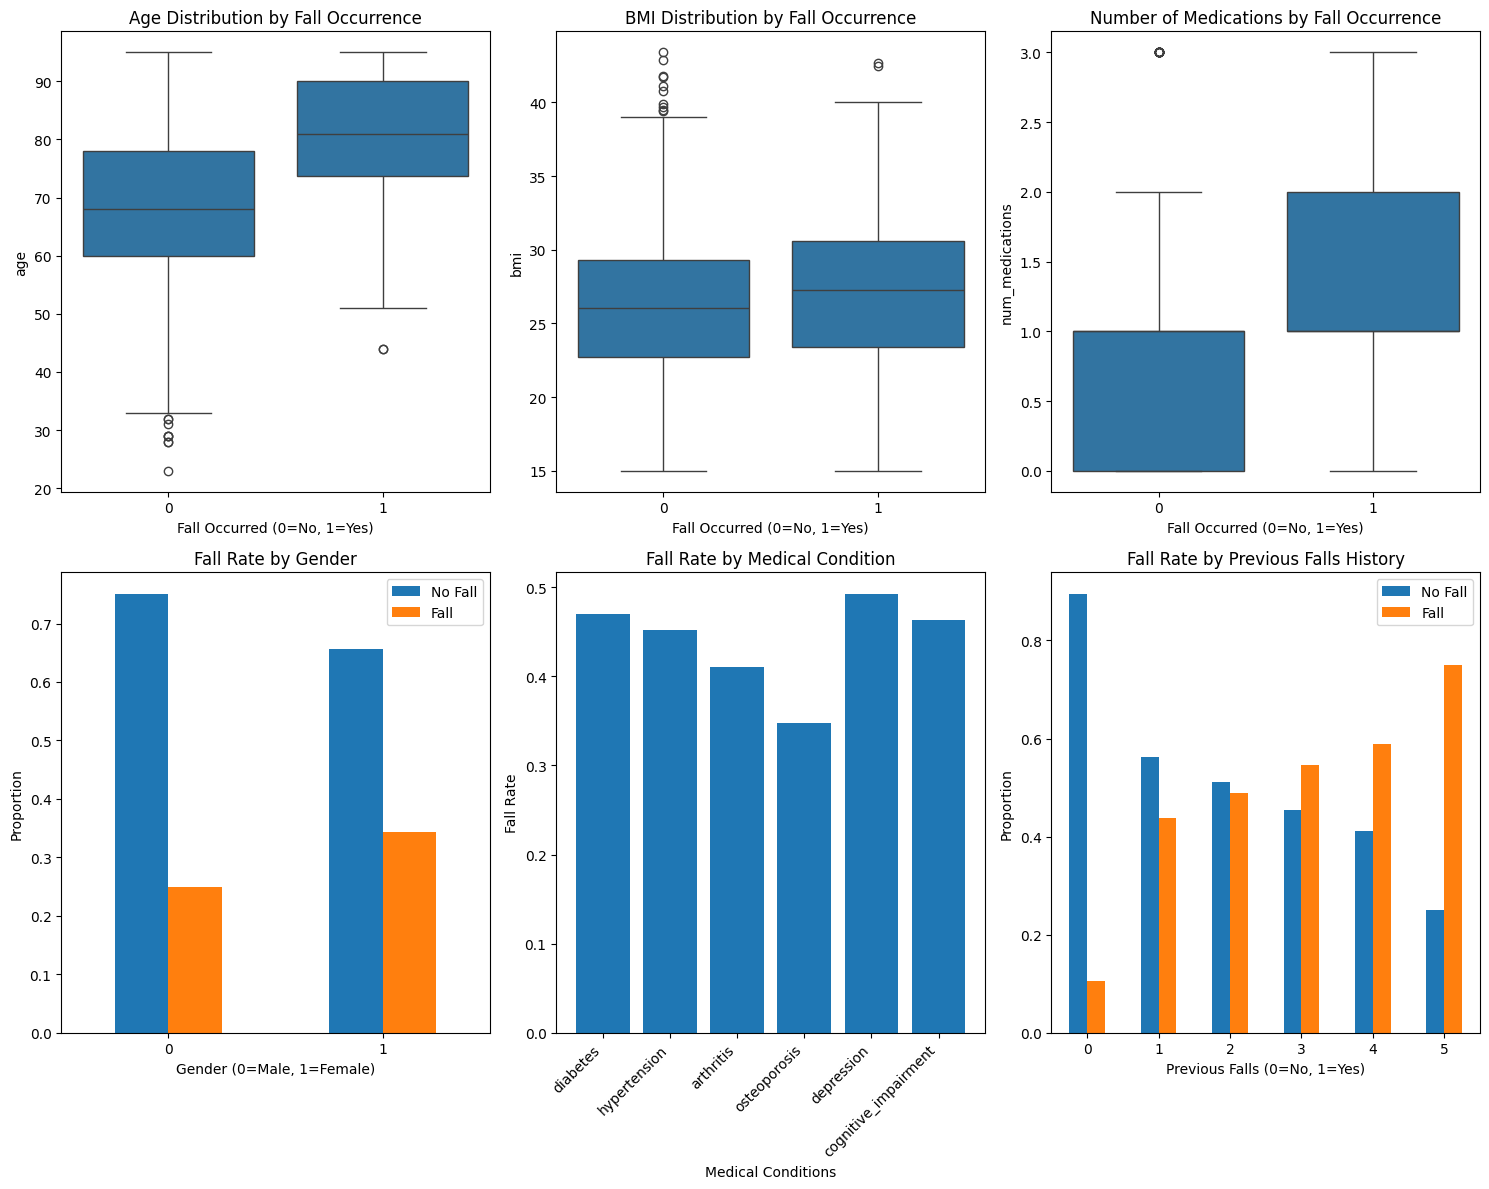

In [42]:
# Create comprehensive visualizations
plt.figure(figsize=(15, 12))

# 1. Age distribution by fall occurrence
plt.subplot(2, 3, 1)
sns.boxplot(data=df, x='fall_occurred', y='age')
plt.title('Age Distribution by Fall Occurrence')
plt.xlabel('Fall Occurred (0=No, 1=Yes)')

# 2. BMI distribution by fall occurrence
plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='fall_occurred', y='bmi')
plt.title('BMI Distribution by Fall Occurrence')
plt.xlabel('Fall Occurred (0=No, 1=Yes)')

# 3. Number of medications by fall occurrence
plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='fall_occurred', y='num_medications')
plt.title('Number of Medications by Fall Occurrence')
plt.xlabel('Fall Occurred (0=No, 1=Yes)')

# 4. Gender distribution
plt.subplot(2, 3, 4)
gender_fall = pd.crosstab(df['gender'], df['fall_occurred'], normalize='index')
gender_fall.plot(kind='bar', ax=plt.gca())
plt.title('Fall Rate by Gender')
plt.xlabel('Gender (0=Male, 1=Female)')
plt.ylabel('Proportion')
plt.legend(['No Fall', 'Fall'])
plt.xticks(rotation=0)

# 5. Medical conditions impact
plt.subplot(2, 3, 5)
conditions = ['diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment']
fall_rates = []
for condition in conditions:
    fall_rate = df[df[condition] == 1]['fall_occurred'].mean()
    fall_rates.append(fall_rate)

plt.bar(range(len(conditions)), fall_rates)
plt.title('Fall Rate by Medical Condition')
plt.xlabel('Medical Conditions')
plt.ylabel('Fall Rate')
plt.xticks(range(len(conditions)), conditions, rotation=45, ha='right')

# 6. Previous falls impact
plt.subplot(2, 3, 6)
prev_falls_crosstab = pd.crosstab(df['previous_falls'], df['fall_occurred'], normalize='index')
prev_falls_crosstab.plot(kind='bar', ax=plt.gca())
plt.title('Fall Rate by Previous Falls History')
plt.xlabel('Previous Falls (0=No, 1=Yes)')
plt.ylabel('Proportion')
plt.legend(['No Fall', 'Fall'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

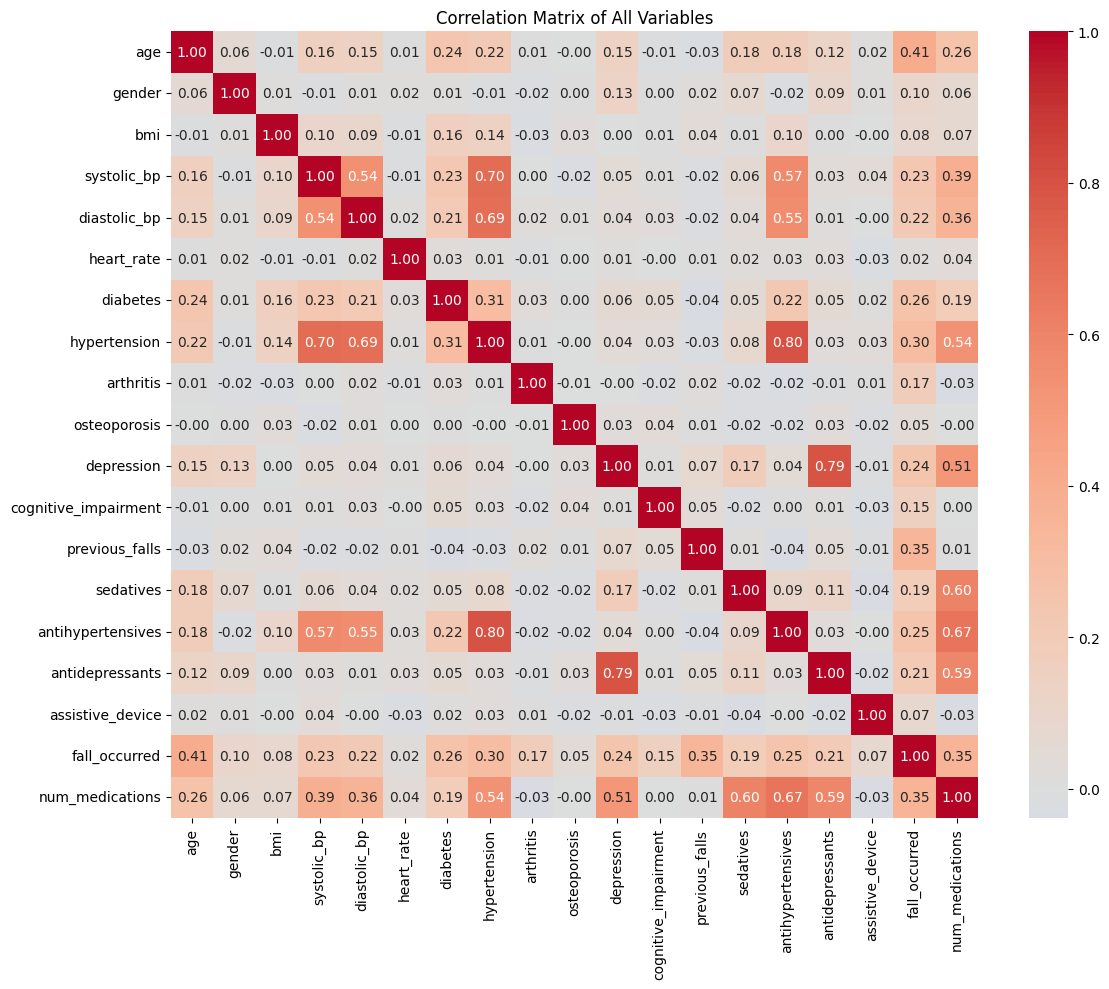

In [43]:
# Create correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop('patient_id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()

In [44]:
# Analyze key risk factors
print("=== FALL RISK ANALYSIS ===")
print("\
1. DEMOGRAPHIC FACTORS:")
print("Average age of patients who fell:", df[df['fall_occurred'] == 1]['age'].mean())
print("Average age of patients who didn't fall:", df[df['fall_occurred'] == 0]['age'].mean())
print("""

""")
print("\
Gender distribution:")
gender_stats = df.groupby(['gender', 'fall_occurred']).size().unstack(fill_value=0)
gender_stats['fall_rate'] = gender_stats[1] / (gender_stats[0] + gender_stats[1])
print(gender_stats)
print("""

""")

print("\
2. MEDICAL CONDITIONS IMPACT:")
conditions = ['diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment']
for condition in conditions:
    with_condition = df[df[condition] == 1]['fall_occurred'].mean()
    without_condition = df[df[condition] == 0]['fall_occurred'].mean()
    print(condition + " - With: " + str(round(with_condition, 3)) + ", Without: " + str(round(without_condition, 3)))
print("""

""")

print("\
3. MEDICATION FACTORS:")
medications = ['sedatives', 'antihypertensives', 'antidepressants']
for med in medications:
    with_med = df[df[med] == 1]['fall_occurred'].mean()
    without_med = df[df[med] == 0]['fall_occurred'].mean()
    print(med + " - With: " + str(round(with_med, 3)) + ", Without: " + str(round(without_med, 3)))
print("""

""")

print("\
Average number of medications:")
print("Patients who fell:", df[df['fall_occurred'] == 1]['num_medications'].mean())
print("Patients who didn't fall:", df[df['fall_occurred'] == 0]['num_medications'].mean())
print("""

""")

print("\
4. PREVIOUS FALLS:")
prev_falls_stats = df.groupby(['previous_falls', 'fall_occurred']).size().unstack(fill_value=0)
prev_falls_stats['fall_rate'] = prev_falls_stats[1] / (prev_falls_stats[0] + prev_falls_stats[1])
print(prev_falls_stats)

=== FALL RISK ANALYSIS ===
1. DEMOGRAPHIC FACTORS:
Average age of patients who fell: 80.885
Average age of patients who didn't fall: 68.50785714285715



Gender distribution:
fall_occurred    0    1  fall_rate
gender                            
0              699  233   0.250000
1              701  367   0.343633



2. MEDICAL CONDITIONS IMPACT:
diabetes - With: 0.47, Without: 0.213
hypertension - With: 0.452, Without: 0.177
arthritis - With: 0.41, Without: 0.242
osteoporosis - With: 0.348, Without: 0.289
depression - With: 0.492, Without: 0.235
cognitive_impairment - With: 0.463, Without: 0.27



3. MEDICATION FACTORS:
sedatives - With: 0.47, Without: 0.258
antihypertensives - With: 0.442, Without: 0.205
antidepressants - With: 0.484, Without: 0.249



Average number of medications:
Patients who fell: 1.2566666666666666
Patients who didn't fall: 0.6328571428571429



4. PREVIOUS FALLS:
fall_occurred     0    1  fall_rate
previous_falls                     
0               811   96   0

In [45]:
# Import necessary libraries for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
# import xgboost as xgb

In [46]:
# Prepare the data for machine learning
# Remove patient_id as it's not a predictive feature
X = df.drop(['patient_id', 'fall_occurred'], axis=1)
y = df['fall_occurred']

print("Feature columns:")
print(list(X.columns))
print("\nDataset shape:", X.shape)
print("Target distribution:")
print(y.value_counts())
print("Fall rate:", y.mean())

Feature columns:
['age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment', 'previous_falls', 'sedatives', 'antihypertensives', 'antidepressants', 'assistive_device', 'num_medications']

Dataset shape: (2000, 18)
Target distribution:
fall_occurred
0    1400
1     600
Name: count, dtype: int64
Fall rate: 0.3


In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training fall rate:", y_train.mean())
print("Test fall rate:", y_test.mean())

Training set size: (1600, 18)
Test set size: (400, 18)
Training fall rate: 0.3
Test fall rate: 0.3


Feature columns:
['age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'diabetes', 'hypertension', 'arthritis', 'osteoporosis', 'depression', 'cognitive_impairment', 'previous_falls', 'sedatives', 'antihypertensives', 'antidepressants', 'assistive_device', 'num_medications']

Dataset shape: (2000, 18)
Target distribution:


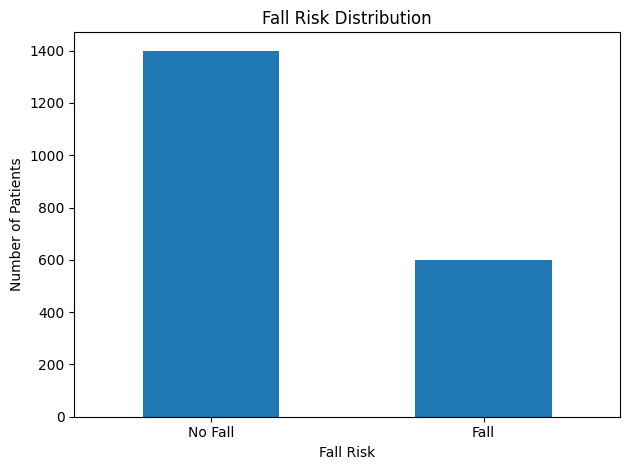

In [48]:
# Prepare the data for machine learning
# Remove patient_id as it's not a predictive feature
X = df.drop(['patient_id', 'fall_occurred'], axis=1)
y = df['fall_occurred']

print("Feature columns:")
print(list(X.columns))
print("\nDataset shape:", X.shape)
print("Target distribution:")
y.value_counts().sort_index().plot(kind='bar')
plt.xticks(ticks=[0, 1], labels=['No Fall', 'Fall'], rotation=0)
plt.title('Fall Risk Distribution')
plt.xlabel('Fall Risk')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

In [49]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training fall rate:", y_train.mean())
print("Test fall rate:", y_test.mean())

Training set size: (1400, 18)
Test set size: (600, 18)
Training fall rate: 0.2957142857142857
Test fall rate: 0.31


In [50]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import average_precision_score


In [64]:
# Train multiple models and compare their performance
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),

}

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate each model
model_results = {}
for name, model in models.items():
    print("Training " + name + "...")
    
    # Use scaled data for SVM and Logistic Regression
    # if name in ['SVM', 'Logistic Regression']:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    # else:
    #     model.fit(X_train, y_train)
    #     y_pred = model.predict(X_test)
    #     y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    auc_score = roc_auc_score(y_test, y_pred_proba)
    # print("\n ")
    cm = confusion_matrix(y_test, y_pred)

    # Calculate additional metrics
    sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # True Positive Rate
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # True Negative Rate
    precision = cm[1,1] / (cm[1,1] + cm[0,1])   # Positive Predictive Value
    npv = cm[0,0] / (cm[0,0] + cm[1,0])         # Negative Predictive Value
    F1score = 2 * (precision*sensitivity)/(precision+sensitivity)
    avg_precision = average_precision_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'f1 score': F1score,
        'average precision': avg_precision,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(name + " - Accuracy: " + str(round(accuracy, 3)) + ",\n AUC: " + str(round(auc_score, 3)) + ",\n F1 Score: " + str(round(F1score, 3))+",\n Avg Precision Score: " + str(round(avg_precision, 3))+"\n")

print("\nModel comparison complete!")

Training Random Forest...
Random Forest - Accuracy: 0.838,
 AUC: 0.917,
 F1 Score: 0.716,
 Avg Precision Score: 0.623

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.857,
 AUC: 0.928,
 F1 Score: 0.758,
 Avg Precision Score: 0.661

Training Logistic Regression...
Logistic Regression - Accuracy: 0.843,
 AUC: 0.917,
 F1 Score: 0.737,
 Avg Precision Score: 0.635

Training SVM...
SVM - Accuracy: 0.858,
 AUC: 0.917,
 F1 Score: 0.762,
 Avg Precision Score: 0.665

Training XGBoost...
XGBoost - Accuracy: 0.837,
 AUC: 0.923,
 F1 Score: 0.731,
 Avg Precision Score: 0.623

Training AdaBoost...
AdaBoost - Accuracy: 0.865,
 AUC: 0.938,
 F1 Score: 0.777,
 Avg Precision Score: 0.679


Model comparison complete!


In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    average_precision_score
)

# 1) Prepare scaler and scaled splits
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) Train and evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
}

results = {}
for name, model in models.items():
    # choose scaled or unscaled
    if name in ['SVM', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        X_eval, y_eval = X_test_scaled, y_test
    else:
        model.fit(X_train, y_train)
        X_eval, y_eval = X_test, y_test

    y_pred      = model.predict(X_eval)
    y_proba     = model.predict_proba(X_eval)[:, 1]
    cm          = confusion_matrix(y_eval, y_pred)
    
    # basic metrics
    accuracy    = (y_pred == y_eval).mean()
    auc_score   = roc_auc_score(y_eval, y_proba)
    avg_prec    = average_precision_score(y_eval, y_proba)
    
    # derived metrics
    sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
    precision   = cm[1,1] / (cm[1,1] + cm[0,1])
    f1_score    = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    results[name] = {
        'accuracy':          accuracy,
        'auc':               auc_score,
        'f1_score':          f1_score,
        'average_precision': avg_prec,
    }

# 3) Convert to DataFrame
summary_df = pd.DataFrame(results).T

# 4) (Optional) round for readability
summary_df = summary_df.round(3)
summary_df.sort_values(by='auc', ascending=False)


,accuracy,auc,f1_score,average_precision
AdaBoost,0.865,0.938,0.777,0.885
Gradient Boosting,0.857,0.928,0.758,0.862
XGBoost,0.837,0.923,0.731,0.851
Random Forest,0.840,0.917,0.718,0.835
Logistic Regression,0.843,0.917,0.737,0.851
SVM,0.858,0.917,0.762,0.842


In [82]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pandas as pd

# 1) Define your models (scale only LR & SVM)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(probability=True, random_state=42))
    ]),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
}

# 2) Set up stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Metrics to compute
scoring = ['accuracy', 'roc_auc', 'f1', 'average_precision']

# 4) Run CV and collect results
results = []
for name, model in models.items():
    cv_res = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    results.append({
        'model': name,
        'accuracy_mean':      cv_res['test_accuracy'].mean(),
        'auc_mean':           cv_res['test_roc_auc'].mean(),
        'f1_mean':            cv_res['test_f1'].mean(),
        'avg_prec_mean':      cv_res['test_average_precision'].mean(),
    })

# 5) Build and display summary DataFrame
summary_df = pd.DataFrame(results).set_index('model')
# Sort by primary metric (e.g. f1_mean)
summary_df = summary_df.sort_values('auc_mean', ascending=False)
summary_df


,accuracy_mean,auc_mean,f1_mean,avg_prec_mean
model,,,,
AdaBoost,0.8685,0.938375,0.768061,0.873660
Gradient Boosting,0.8650,0.934530,0.757221,0.864852
Logistic Regression,0.8510,0.923429,0.740892,0.841150
XGBoost,0.8495,0.922917,0.742895,0.841047
SVM,0.8555,0.922744,0.740348,0.841122
Random Forest,0.8430,0.918054,0.712294,0.829583


In [52]:
# Select the best model and analyze feature importance
best_model_name = 'Logistic Regression'
best_model = model_results[best_model_name]['model']


print("Best Model: " + best_model_name)
print("Test Accuracy: " + str(round(model_results[best_model_name]['accuracy'], 3)))
print("Test AUC: " + str(round(model_results[best_model_name]['auc'], 3)))
print("Test F1 Score: " + str(round(model_results[best_model_name]['f1 score'], 3)))
print("Test Avg Precision: " + str(round(model_results[best_model_name]['average precision'], 3)))


Best Model: Logistic Regression
Test Accuracy: 0.843
Test AUC: 0.917
Test F1 Score: 0.737
Test Avg Precision: 0.635


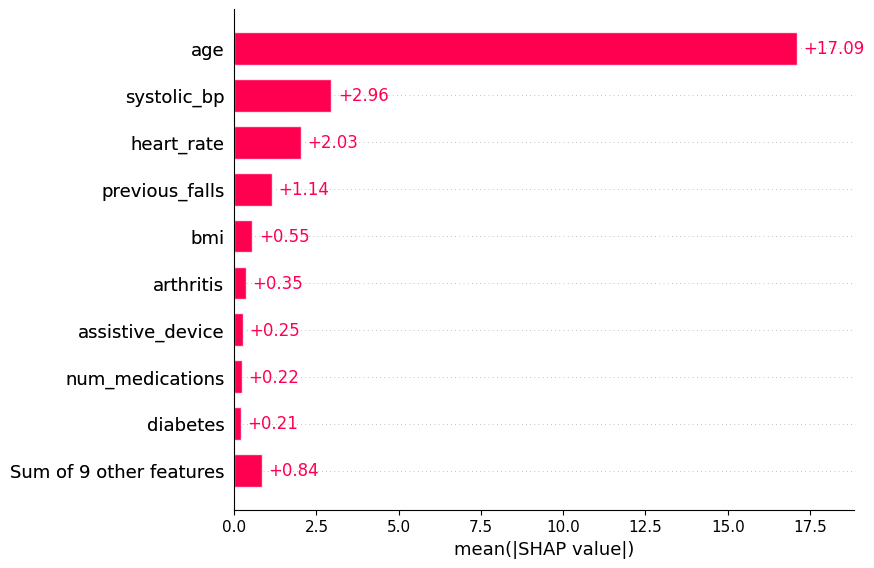

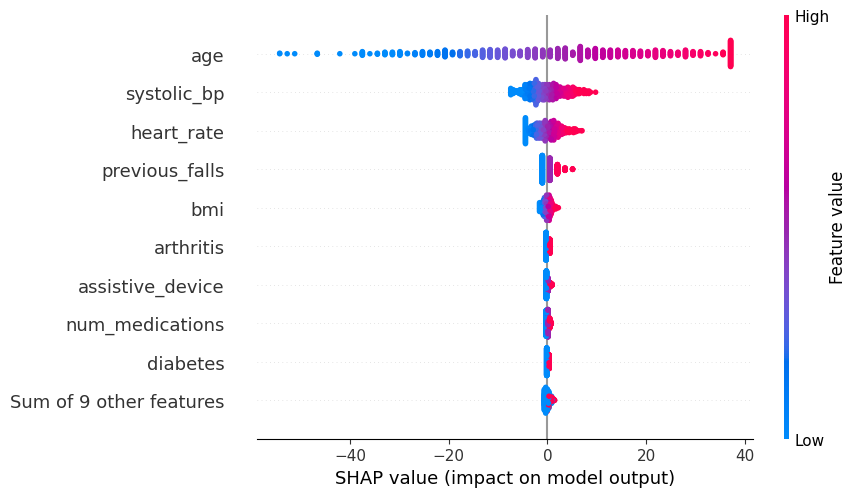

In [ ]:
# SHAP explainer
explainer = shap.Explainer(model_results[best_model_name]['model'], X_train)
shap_values = explainer(X_test)


# Summary plot (bar chart)
shap.plots.bar(shap_values)

# # # Optional: beeswarm plot
shap.plots.beeswarm(shap_values)




In [59]:
ada = AdaBoostClassifier(n_estimators=1000, random_state=42)
ada.fit(X_train, y_train)
# background = shap.sample(X_train, 500)
# explainer = shap.KernelExplainer(model_results['AdaBoost']['model'].predict, background)    # or X_train
# shap_values = explainer.shap_values(X_test)


# shap.summary_plot(shap_values, X_test)

feature_importance = ada.feature_importances_
feature_names = X.columns.tolist()

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Get top 10 features
top_10_features = importance_df.sort_values('importance', ascending=False).head(10)

print("Top 10 Most Important Features:")
print(top_10_features.to_string(index=False))

# Print model accuracy
from sklearn.metrics import accuracy_score
y_pred = ada.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

Top 10 Most Important Features:
             feature  importance
                 age    0.204668
          heart_rate    0.190745
         systolic_bp    0.184713
      previous_falls    0.137793
                 bmi    0.044588
        diastolic_bp    0.041892
cognitive_impairment    0.030258
           arthritis    0.030217
    assistive_device    0.023237
            diabetes    0.021358

Model Accuracy: 0.8650


,accuracy_mean,auc_mean,f1_mean,avg_prec_mean
model,,,,
AdaBoost,0.865714,0.931551,0.763781,0.857002
Gradient Boosting,0.862143,0.919567,0.752003,0.831068
Logistic Regression,0.855714,0.926190,0.742257,0.841085
XGBoost,0.847857,0.904943,0.728514,0.801117
SVM,0.850000,0.916966,0.726417,0.822334
Random Forest,0.845000,0.907186,0.709658,0.810691


Detailed Classification Report:
              precision    recall  f1-score   support

     No Fall       0.87      0.90      0.89       414
        Fall       0.77      0.71      0.74       186

    accuracy                           0.84       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.84      0.84      0.84       600


Confusion Matrix:


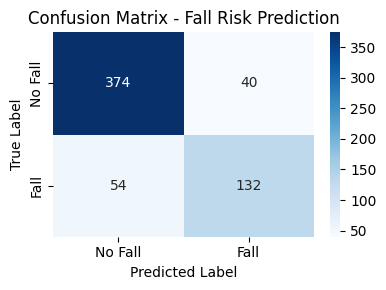

True Negatives: 374
False Positives: 40
False Negatives: 54
True Positives: 132

Additional Metrics:
Sensitivity (Recall): 0.71
Specificity: 0.903
Precision: 0.767
Negative Predictive Value: 0.874
F1 Score: 0.737


In [54]:
# Create detailed classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred_best = model_results[best_model_name]['predictions']

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Fall', 'Fall']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
labels = ['No Fall', 'Fall']
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fall Risk Prediction')
plt.tight_layout()
plt.show()
print("True Negatives:", cm[0,0])
print("False Positives:", cm[0,1]) 
print("False Negatives:", cm[1,0])
print("True Positives:", cm[1,1])

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # True Positive Rate
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # True Negative Rate
precision = cm[1,1] / (cm[1,1] + cm[0,1])   # Positive Predictive Value
npv = cm[0,0] / (cm[0,0] + cm[1,0])         # Negative Predictive Value
F1 = 2 * (precision*sensitivity)/(precision+sensitivity)

print("\nAdditional Metrics:")
print("Sensitivity (Recall): " + str(round(sensitivity, 3)))
print("Specificity: " + str(round(specificity, 3)))
print("Precision: " + str(round(precision, 3)))
print("Negative Predictive Value: " + str(round(npv, 3)))
print("F1 Score: "+str(round(F1, 3)))